# 총정리 코드

## 1. 데이터 살펴보기

### 1.0 라이브러리 선언 및 데이터 불러오기

In [1]:
import os 
import pandas as pd
import numpy as np
import re

import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Malgun Gothic'  # (Windows 용) 한글 출력을 위한 글꼴 설정

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

# 랜덤시드 통일
np.random.seed(42)

In [2]:
def get_font_family():
    """
    시스템 환경에 따른 기본 폰트명을 반환하는 함수
    """
    import platform
    system_name = platform.system()
    # colab 사용자는 system_name이 'Linux'로 확인

    if system_name == "Darwin" :
        font_family = "AppleGothic"
    elif system_name == "Windows":
        font_family = "Malgun Gothic"
    else:
        # Linux
        # colab에서는 runtime을 <꼭> 재시작 해야함.
        # 런타임을 재시작 하지 않고 폰트 설치를 하면 기본 설정 폰트가 로드되어 한글이 깨짐.
        !apt-get update -qq
        !apt-get install fonts-nanum -qq  > /dev/null

        import matplotlib.font_manager as fm

        fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
        font = fm.FontProperties(fname=fontpath, size=9)
        fm._rebuild()
        font_family = "NanumBarunGothic"
    return font_family

In [3]:
# 시각화를 위한 폰트설정
# 위에서 만든 함수를 통해 시스템 폰트를 불러와서 font_family 라는 변수에 할당.
a = get_font_family()
# 폰트설정
import matplotlib.pyplot as plt 
plt.rc("font", family = a)
# 마이너스폰트 설정
plt.rc("axes", unicode_minus=False)
# ggplot으로 그래프 스타일 설정 / 개인 자유
plt.style.use("ggplot")

In [4]:
# 데이터 확인
os.listdir('data')

['2020교통량통합.xlsx',
 'check.csv',
 'final.csv',
 'holiday.csv',
 'metro.csv',
 '교통량정리.csv',
 '국가공휴일.xlsx',
 '기상청.csv',
 '디지털 스킬셋 기술과제.docx',
 '서울시_기상데이터.csv',
 '실전db.csv',
 '실전db_holiday.csv',
 '지하철노선위경도정보3.xlsx',
 '최종.csv']

In [5]:
# 데이터프레임 불러오기
df = pd.read_csv("./data/실전db.csv")

### 1.1 데이터 탐색

In [6]:
# 데이터 내부 살펴보기 함수
def search_data(df):
    print("데이터 확인 :")
    display(df.head())
    print()
    print()
    
    print("데이터 살펴보기 :")
    display(df.describe())
    print()
    print()    
    
    print("데이터 정보 확인 :")
    print(df.info())
    print()
    print()
        
    print("데이터 형태 확인 :", df.shape)
    print()
    print()
    
    print("결측치 확인 :")
    print(df.isna().sum())
    print()
    print()
    
    print("유니크값 확인 :")
    for col in df.columns:
        print(f"column : {col}")
        print(f"The number of unique : {df[col].nunique()}")
        print()

In [7]:
search_data(df)

데이터 확인 :


,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1
0,2858,2014-01-07,AA,1892,A,2020-01-01,1,GN
1,5647,2014-02-14,BB,182009,A,2020-01-01,1,J
2,33314,2014-11-20,BB,82431,A,2020-01-01,1,SC
3,37001,2014-12-04,BB,725,C,2020-01-01,1,MP
4,37819,2014-12-07,AA,220691,C,2020-01-01,1,JRR




데이터 살펴보기 :


,USER_ID,STORE_ID,COUNT
count,8.792710e+05,879271.000000,879271.000000
mean,1.206566e+06,149599.960642,1.029079
std,4.206529e+05,68898.035318,0.512428
min,2.240000e+02,4.000000,1.000000
25%,9.005760e+05,92437.000000,1.000000
50%,1.321440e+06,173059.000000,1.000000
75%,1.542416e+06,220661.000000,1.000000
max,1.830598e+06,231465.000000,61.000000




데이터 정보 확인 :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 879271 entries, 0 to 879270
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   USER_ID     879271 non-null  int64 
 1   JOIN_DATE   879271 non-null  object
 2   D_TYPE      879271 non-null  object
 3   STORE_ID    879271 non-null  int64 
 4   GOODS_TYPE  879271 non-null  object
 5   DATE        879271 non-null  object
 6   COUNT       879271 non-null  int64 
 7   AD1         879271 non-null  object
dtypes: int64(3), object(5)
memory usage: 53.7+ MB
None


데이터 형태 확인 : (879271, 8)


결측치 확인 :
USER_ID       0
JOIN_DATE     0
D_TYPE        0
STORE_ID      0
GOODS_TYPE    0
DATE          0
COUNT         0
AD1           0
dtype: int64


유니크값 확인 :
column : USER_ID
The number of unique : 165425

column : JOIN_DATE
The number of unique : 2352

column : D_TYPE
The number of unique : 3

column : STORE_ID
The number of unique : 1061

column : GOODS_TYPE
The number of u

### 1.2 데이터 탐색 및 시각화를 위한 기초 전처리

In [8]:
# JOIN_DATE와 DATE는 datetime 형태로 바꾼다
df.JOIN_DATE = pd.to_datetime(df.JOIN_DATE) 
df.DATE = pd.to_datetime(df.DATE)

In [9]:
# JOIN_DATE는 년도로 바꾼다.
df.JOIN_DATE = df.JOIN_DATE.dt.to_period(freq="A") 
df.JOIN_DATE = df.JOIN_DATE.astype(str)

In [10]:
# DATE는 월별로 묶어서 새로운 컬럼을 생성
df["MONTH"] = df.DATE.dt.strftime('%m')

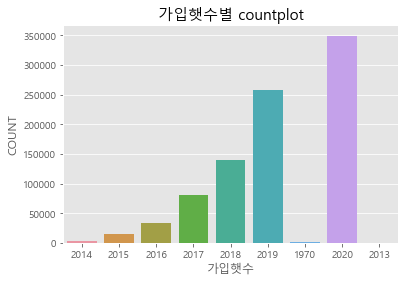

In [11]:
## 이윤지님 코드!!

## 가입년도 별 countplot
sns.countplot(x='JOIN_DATE',data=df)
plt.xlabel('가입햇수')
plt.ylabel('COUNT')
plt.title('가입햇수별 countplot', fontsize=15)

plt.show()

In [12]:
df['DATE_YEAR'] = df['DATE'].dt.to_period(freq="A")
df['DATE_YEAR'] = df['DATE_YEAR'].astype(str)
df['DATE_YEAR'] = df['DATE_YEAR'].astype(int)
df['JOIN_DATE'] = df['JOIN_DATE'].astype(int)
years = []
for i in range(len(df)):
    years.append(int(df['DATE_YEAR'][i]) - int(df['JOIN_DATE'][i]))
df['YEARS'] = years
df

,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1,MONTH,DATE_YEAR,YEARS
0,2858,2014,AA,1892,A,2020-01-01,1,GN,01,2020,6
1,5647,2014,BB,182009,A,2020-01-01,1,J,01,2020,6
2,33314,2014,BB,82431,A,2020-01-01,1,SC,01,2020,6
3,37001,2014,BB,725,C,2020-01-01,1,MP,01,2020,6
4,37819,2014,AA,220691,C,2020-01-01,1,JRR,01,2020,6
...,...,...,...,...,...,...,...,...,...,...,...
879266,1830551,2020,BB,219886,B,2020-12-31,1,GN,12,2020,0
879267,1830570,2020,BB,82433,B,2020-12-31,1,CY,12,2020,0
879268,1830580,2020,AA,92020,B,2020-12-31,1,JRR,12,2020,0
879269,1830589,2020,BB,92437,B,2020-12-31,1,J,12,2020,0


In [13]:
# 이윤지님 코드!!
## 신규가입자와 이전 가입자 구분 COUNT 시각화
# 신규 가입자 (0년~3년)만 따로 df 생성해서 확인

df['YEARS'] = df['YEARS'].astype(int)

newbi = df[df['YEARS'] <= 3]
ob = df[df['YEARS'] > 3]

newbi.reset_index(inplace=True)
ob.reset_index(inplace=True)
newbi.drop('index', axis=1, inplace=True)
ob.drop('index', axis=1, inplace=True)

df['JOIN_DATE'] = df["JOIN_DATE"].astype(str)

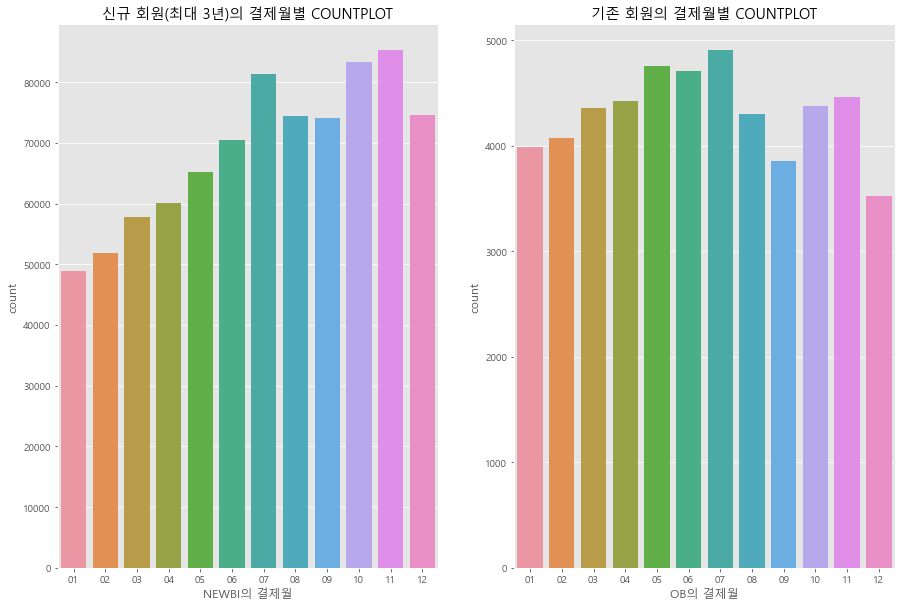

In [14]:
## 이윤지님 코드!!

# 신규 및 이전 가입자 COUNT 시각화
plt.rcParams['figure.figsize'] = [15,10]
plt.subplot(121)
sns.countplot(x=newbi['MONTH'], data=newbi)
plt.xlabel('NEWBI의 결제월')
plt.title('신규 회원(최대 3년)의 결제월별 COUNTPLOT')

plt.subplot(122)
sns.countplot(x=ob['MONTH'], data=ob)
plt.xlabel('OB의 결제월')
plt.title('기존 회원의 결제월별 COUNTPLOT')
plt.show()

In [15]:
df = df.drop(['DATE_YEAR','YEARS'], axis=1)

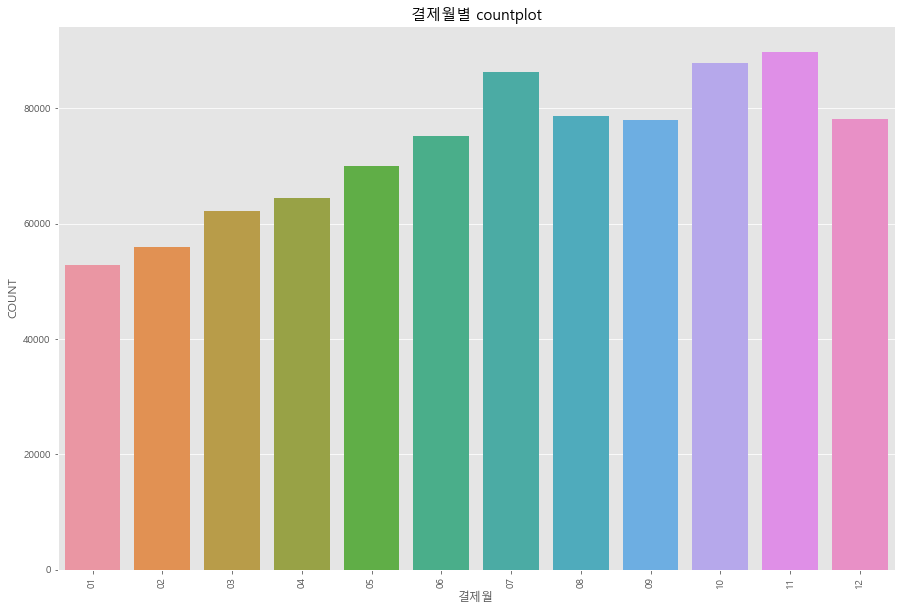

In [16]:
## 이윤지님 코드

sns.countplot(x=df['MONTH'],data=df)
plt.xticks(rotation=90)
plt.xlabel('결제월')
plt.ylabel('COUNT')
plt.title('결제월별 countplot', fontsize=15)
plt.show()

In [17]:
# StoreID는 주차장 장소로 추정 / 장소에 따른 유저, 이용수 확인

store_list = df['STORE_ID'].unique()
store_user_list = []

for store in store_list :
    store_df = df[df['STORE_ID']==store]
    store_user_list.append(store_df['USER_ID'].nunique())
    
store_user = pd.DataFrame([store_list, store_user_list])

store_user = store_user.T

store_user.columns = ['STORE_ID', 'USER_NUM']

display(store_user)

,STORE_ID,USER_NUM
0,1892,1040
1,182009,690
2,82431,2729
3,725,1976
4,220691,752
...,...,...
1056,231127,1
1057,230952,1
1058,231135,1
1059,231427,1


### 1.3 시각화 진행

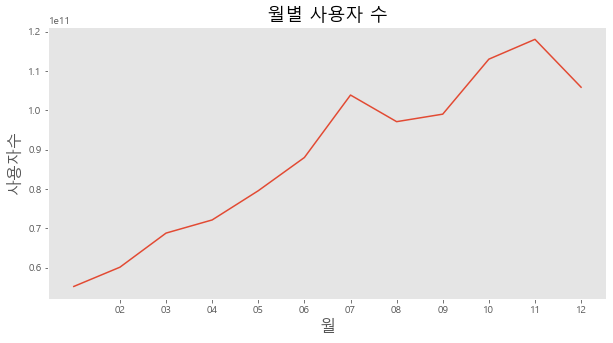

In [18]:
# 월별로 유저 수 파악

plt.figure(figsize=(10,5))
# x축 y축 설정
sns.lineplot(df['MONTH'].unique(),df.groupby("MONTH")["USER_ID"].sum()) # 2010년   
plt.grid()
plt.xticks(np.arange(1, 12, step=1)) # 월이면 1~12 / 주간이면 1~53 / ~~
plt.title('월별 사용자 수', fontsize=18)
plt.ylabel('사용자수', fontsize=16)
plt.xlabel('월', fontsize=16)
plt.show()

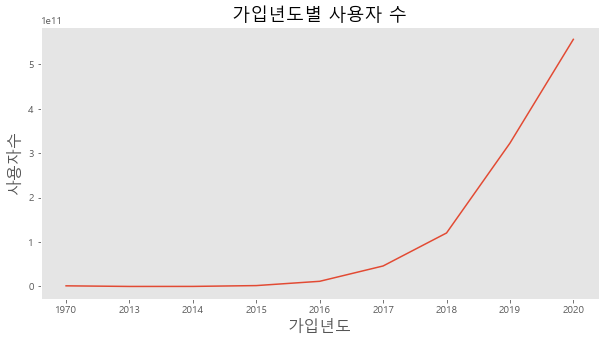

In [19]:
# 가입일자별로 유저 수 파악
plt.figure(figsize=(10,5))
# x축 y축 설정
sns.lineplot(df.groupby("JOIN_DATE")["USER_ID"].sum().keys(),df.groupby("JOIN_DATE")["USER_ID"].sum()) # 2010년   
plt.grid()
plt.title('가입년도별 사용자 수', fontsize=18)
plt.ylabel('사용자수', fontsize=16)
plt.xlabel('가입년도', fontsize=16)
plt.show()

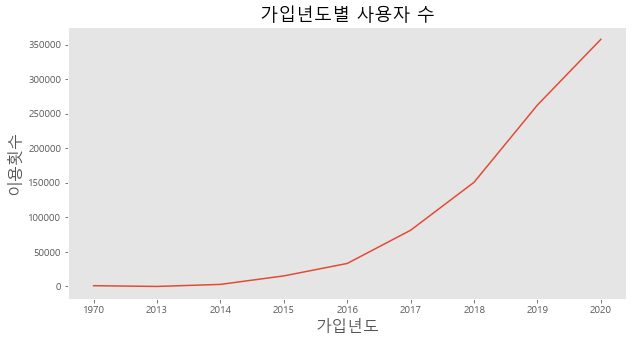

In [20]:
# 가입일자별로 이용횟수 파악
plt.figure(figsize=(10,5))
# x축 y축 설정
sns.lineplot(df.groupby("JOIN_DATE")["COUNT"].sum().keys(),df.groupby("JOIN_DATE")["COUNT"].sum()) # 2010년   
plt.grid()
plt.title('가입년도별 사용자 수', fontsize=18)
plt.ylabel('이용횟수', fontsize=16)
plt.xlabel('가입년도', fontsize=16)
plt.show()

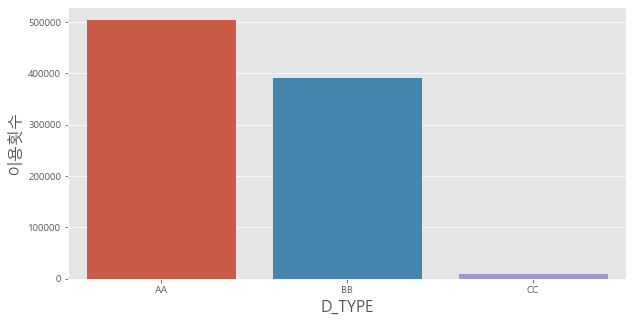

In [21]:
# D_TYPE이 무엇인지 이용횟수별 시각화를 진행해보자.
plt.figure(figsize=(10,5))
sns.barplot(x=df.groupby("D_TYPE")["COUNT"].sum().keys(),y=df.groupby("D_TYPE")["COUNT"].sum())
plt.ylabel('이용횟수', fontsize=16)
plt.xlabel('D_TYPE', fontsize=16)
plt.show()

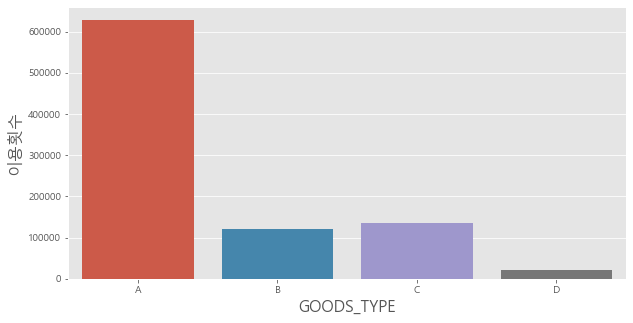

In [22]:
# GOODS_TYPE이 무엇인지 이용횟수별 시각화를 진행해보자.
plt.figure(figsize=(10,5))
sns.barplot(x=df.groupby("GOODS_TYPE")["COUNT"].sum().keys(),y=df.groupby("GOODS_TYPE")["COUNT"].sum())
plt.ylabel('이용횟수', fontsize=16)
plt.xlabel('GOODS_TYPE', fontsize=16)
plt.show()

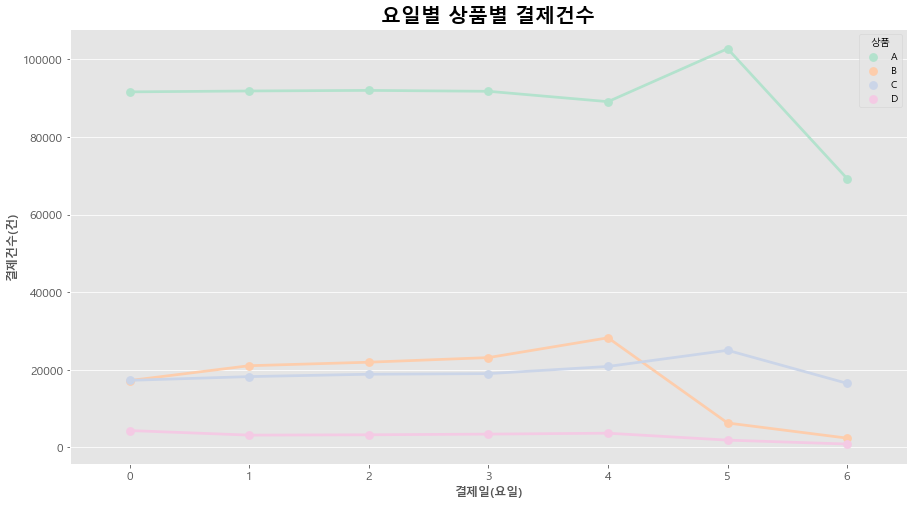

In [23]:
## 최지선님 코드 !!
# 요일별 GOODS_TYPE 소비 파악

df['DAY'] = df['DATE'].dt.weekday

jison_df = df.groupby(['DAY','GOODS_TYPE'])['COUNT'].sum().reset_index()
jison_df = jison_df[['DAY','GOODS_TYPE','COUNT']]
jison_df.columns = ['결제일(요일)','상품','결제건수']

color = sns.set_palette("Pastel2")
fig, ax = plt.subplots(1,1, figsize = (15,8))
sns.pointplot(x = '결제일(요일)', y = '결제건수', hue = '상품', data = jison_df, palette = color)
plt.title('요일별 상품별 결제건수', fontsize = 20, fontweight = 'bold')
plt.xlabel('결제일(요일)', fontsize = 12, fontweight = 'bold')
plt.ylabel('결제건수(건)', fontsize = 12, fontweight = 'bold')
plt.tick_params(axis = 'x', labelsize = 12)
plt.tick_params(axis = 'y', labelsize = 12)
plt.show()

df.drop("DAY", axis=1, inplace=True)

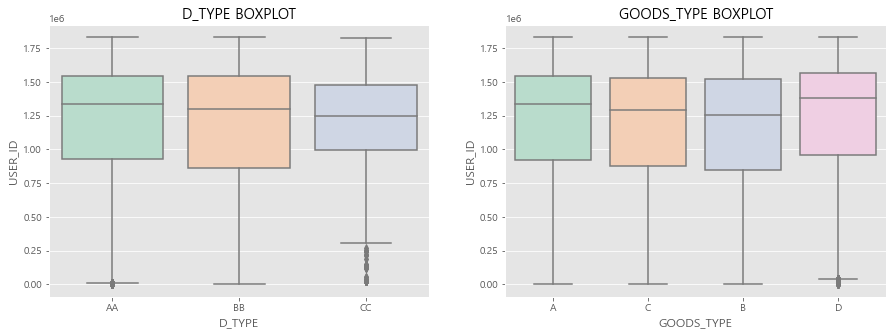

In [24]:
## 이윤지님 코드!!

plt.figure(figsize=(15,5))

plt.subplot(121)
sns.boxplot(x='D_TYPE', y='USER_ID', data=df)

plt.title('D_TYPE BOXPLOT')
plt.ylabel('USER_ID')

plt.subplot(122)
sns.boxplot(x='GOODS_TYPE', y='USER_ID', data=df)

plt.title('GOODS_TYPE BOXPLOT')

plt.show()

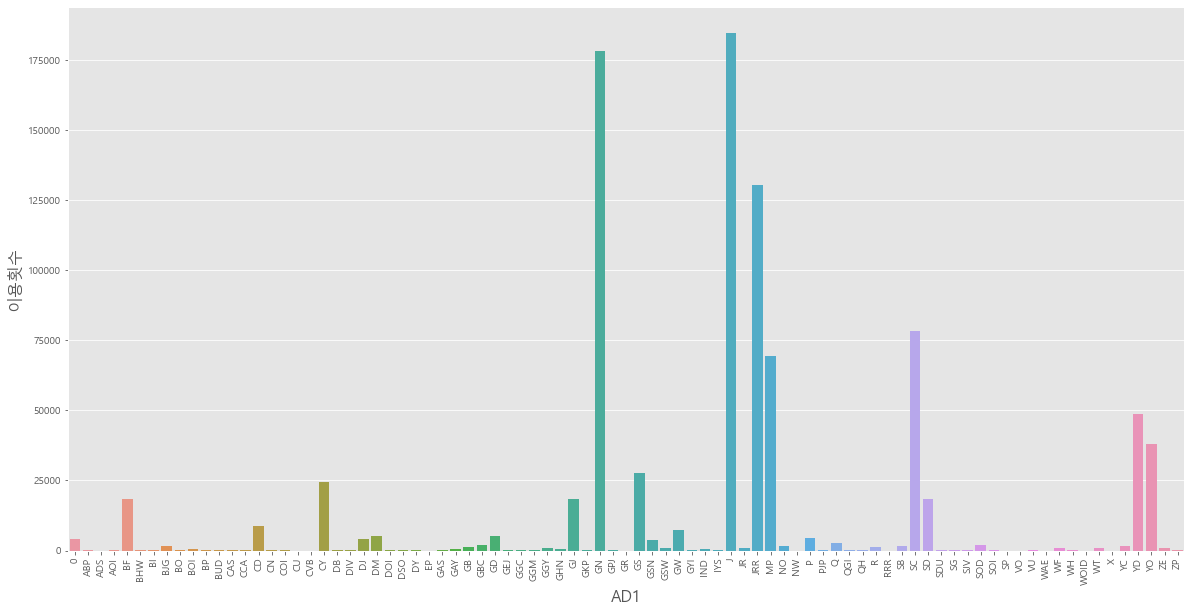

In [25]:
# D_TYPE이 무엇인지 이용횟수별 시각화를 진행해보자.
plt.figure(figsize=(20,10))
sns.barplot(x=df.groupby("AD1")["COUNT"].sum().keys(),y=df.groupby("AD1")["COUNT"].sum())
plt.ylabel('이용횟수', fontsize=16)
plt.xlabel('AD1', fontsize=16)
plt.xticks(rotation='vertical')
plt.show()

In [26]:
# STORE_ID별 유저가 많은 top10을 뽑아보자
store_df = pd.DataFrame(df.groupby('STORE_ID')["USER_ID"].sum())
store_df.sort_values(by='USER_ID', ascending=False).head(10)

,USER_ID
STORE_ID,
220893,21418448316
220557,21410681022
220655,19442030078
220848,19420230250
91853,17757890385
92437,17679433560
105033,17287160942
1109,16408779471
82400,15208812801


## 2. 본격적인 컬럼별 EDA

### 2.1 이상치 없애기

In [27]:
# 이상치 없애기

"""
- 해당 프로젝트의 목표는 '일반 유저의 한달 사용 건수 예측'이다.
- 때문에 일반 유저로 보이지 않는 유저를 제거하여 예측의 정확도를 높인다.
- 이때 이상치로 판단하는 조건은 아래와 같다
    - 짧은 시일 내 연속적으로 이용하는 패턴을 보인다.
    - COUNT가 계속해서 높은 수를 보인다. (일반적인 패턴은 1)
    - AD1 값이 계속해서 바뀐다.
    - 5개 이상의 데이터를 가진다.
"""

"\n- 해당 프로젝트의 목표는 '일반 유저의 한달 사용 건수 예측'이다.\n- 때문에 일반 유저로 보이지 않는 유저를 제거하여 예측의 정확도를 높인다.\n- 이때 이상치로 판단하는 조건은 아래와 같다\n    - 짧은 시일 내 연속적으로 이용하는 패턴을 보인다.\n    - COUNT가 계속해서 높은 수를 보인다. (일반적인 패턴은 1)\n    - AD1 값이 계속해서 바뀐다.\n    - 5개 이상의 데이터를 가진다.\n"

<AxesSubplot:xlabel='COUNT', ylabel='count'>

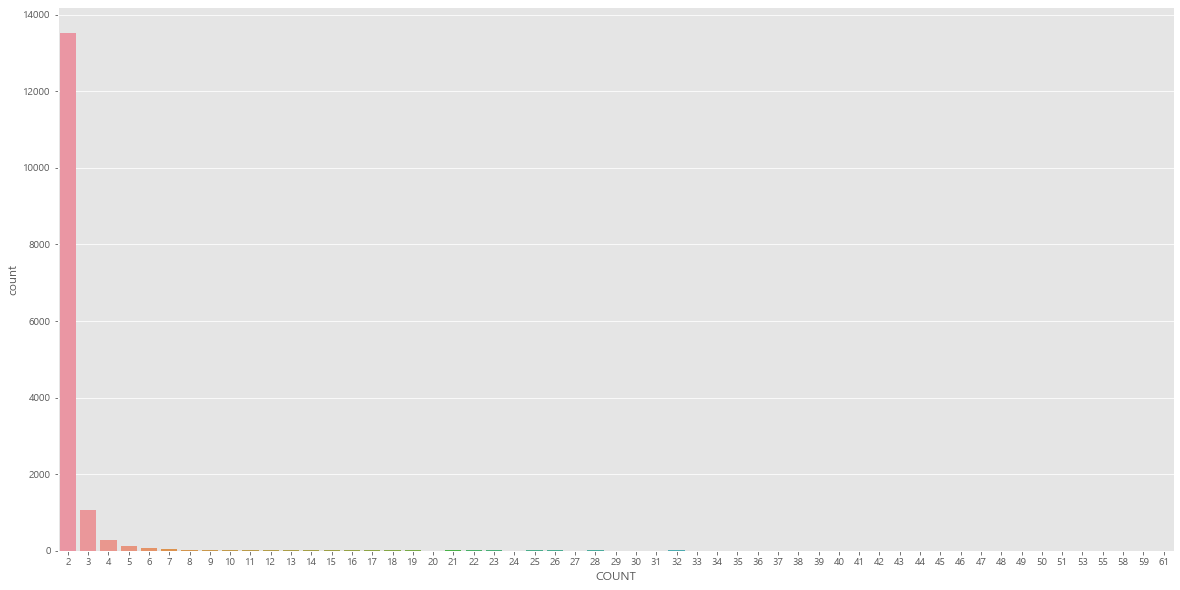

In [28]:
# 최지선님 코드!!
# 결제 건수 2개 이상 데이터 분포 확인
df_count_2 = df[df['COUNT'] >= 2]
df_count_2.groupby(df_count_2['COUNT']).count()

plt.figure(figsize=(20,10))
sns.countplot(data=df_count_2, x='COUNT')

In [29]:
# COUNT가 10개 이상 잡히는 ID 출력
df_outlier = df.query("COUNT > 10")
print("특이값 의심 아이디 개수 :", df_outlier['USER_ID'].nunique())

특이값 의심 아이디 개수 : 16


In [30]:
# 의심 ID display
for x in sorted(df_outlier['USER_ID'].unique()) :
    outlier_df = df[df['USER_ID']==x]
    
    print("USER_ID",x,"의 데이터 흐름입니다.")
    display(outlier_df.head())
    print()
    print()

USER_ID 430741 의 데이터 흐름입니다.


,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1,MONTH
460594,430741,2016,BB,219913,A,2020-07-30,11,GN,07




USER_ID 709657 의 데이터 흐름입니다.


,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1,MONTH
82442,709657,2018,BB,182296,A,2020-02-16,5,SC,02
107642,709657,2018,BB,182296,A,2020-02-29,9,SC,02
109060,709657,2018,BB,182296,A,2020-03-01,5,SC,03
110138,709657,2018,BB,182296,A,2020-03-02,12,SC,03
112135,709657,2018,BB,182296,A,2020-03-03,3,SC,03




USER_ID 999665 의 데이터 흐름입니다.


,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1,MONTH
372,999665,2018,CC,82399,A,2020-01-01,6,JRR,01
1527,999665,2018,CC,104988,A,2020-01-02,11,GN,01
3121,999665,2018,CC,181832,A,2020-01-03,7,SC,01
5034,999665,2018,CC,109223,A,2020-01-04,28,MP,01
6919,999665,2018,CC,104916,A,2020-01-05,14,GN,01




USER_ID 1304663 의 데이터 흐름입니다.


,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1,MONTH
441453,1304663,2019,AA,220966,A,2020-07-23,1,JRR,07
444575,1304663,2019,AA,220966,A,2020-07-24,13,JRR,07
448022,1304663,2019,AA,220966,A,2020-07-25,10,JRR,07




USER_ID 1407822 의 데이터 흐름입니다.


,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1,MONTH
340038,1407822,2019,BB,222256,A,2020-06-15,1,MP,06
347688,1407822,2019,BB,222256,A,2020-06-18,1,MP,06
350431,1407822,2019,BB,222256,A,2020-06-19,12,MP,06




USER_ID 1467323 의 데이터 흐름입니다.


,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1,MONTH
18750,1467323,2020,AA,220836,A,2020-01-11,5,JRR,01
23725,1467323,2020,AA,220836,B,2020-01-14,3,JRR,01
25448,1467323,2020,AA,220836,B,2020-01-15,5,JRR,01
27154,1467323,2020,AA,220836,B,2020-01-16,8,JRR,01
29330,1467323,2020,AA,220836,B,2020-01-17,2,JRR,01




USER_ID 1514190 의 데이터 흐름입니다.


,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1,MONTH
340338,1514190,2020,AA,220607,A,2020-06-15,2,GN,06
342840,1514190,2020,AA,220607,A,2020-06-16,1,GN,06
345395,1514190,2020,AA,220607,A,2020-06-17,3,GN,06
348010,1514190,2020,AA,220607,A,2020-06-18,5,GN,06
350814,1514190,2020,AA,220607,A,2020-06-19,3,GN,06




USER_ID 1544719 의 데이터 흐름입니다.


,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1,MONTH
208433,1544719,2020,BB,221045,A,2020-04-18,19,GN,04




USER_ID 1572434 의 데이터 흐름입니다.


,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1,MONTH
479354,1572434,2020,AA,1892,B,2020-08-05,1,GN,08
693952,1572434,2020,AA,1892,B,2020-10-26,7,GN,10
696940,1572434,2020,AA,1892,B,2020-10-27,6,GN,10
699967,1572434,2020,AA,1892,B,2020-10-28,7,GN,10
703093,1572434,2020,AA,1892,B,2020-10-29,10,GN,10




USER_ID 1599008 의 데이터 흐름입니다.


,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1,MONTH
734271,1599008,2020,BB,203847,A,2020-11-08,15,SC,11




USER_ID 1613793 의 데이터 흐름입니다.


,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1,MONTH
407266,1613793,2020,AA,222328,A,2020-07-10,2,SB,07
417754,1613793,2020,AA,222328,A,2020-07-14,4,SB,07
501310,1613793,2020,AA,222328,A,2020-08-13,1,SB,08
528066,1613793,2020,AA,222328,A,2020-08-24,1,SB,08
530800,1613793,2020,AA,222328,A,2020-08-25,1,SB,08




USER_ID 1635143 의 데이터 흐름입니다.


,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1,MONTH
476895,1635143,2020,AA,221045,A,2020-08-04,23,GN,08




USER_ID 1660735 의 데이터 흐름입니다.


,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1,MONTH
528423,1660735,2020,BB,220607,A,2020-08-24,1,GN,08
531184,1660735,2020,BB,220607,A,2020-08-25,1,GN,08
533873,1660735,2020,BB,220607,A,2020-08-26,1,GN,08
536620,1660735,2020,BB,220607,A,2020-08-27,2,GN,08
545374,1660735,2020,BB,220607,A,2020-08-31,1,GN,08




USER_ID 1675314 의 데이터 흐름입니다.


,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1,MONTH
618893,1675314,2020,BB,109670,A,2020-09-28,15,CY,09
631720,1675314,2020,BB,1892,A,2020-10-05,5,GN,10
643512,1675314,2020,BB,220440,A,2020-10-09,7,MP,10




USER_ID 1675755 의 데이터 흐름입니다.


,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1,MONTH
604384,1675755,2020,AA,219913,A,2020-09-23,15,GN,09
663843,1675755,2020,AA,223107,D,2020-10-16,1,GS,10
862914,1675755,2020,AA,106328,C,2020-12-24,1,J,12




USER_ID 1775410 의 데이터 흐름입니다.


,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1,MONTH
757192,1775410,2020,BB,92505,A,2020-11-15,17,J,11


In [31]:
"""
해당 조건에 만족하는 ID를 선별한다.
- 연속적으로 이용
- 데이터가 5개 이상
- AD1이 계속해서 바뀜
- COUMT 값의 평균이 비정상적으로 높음
"""
outlier_user_list = [999665, 1572434, 1572434] # 뒤에 두 개는 AD1값이 바뀌지 않지만 넣어서 확인한다.

for z in outlier_user_list :
    outlier_user_df = df[df['USER_ID']==z]
    
    print("USER_ID",z,"의 데이터 흐름입니다.")
    display(outlier_user_df.head(50))
    print()
    print()

USER_ID 999665 의 데이터 흐름입니다.


,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1,MONTH
372,999665,2018,CC,82399,A,2020-01-01,6,JRR,01
1527,999665,2018,CC,104988,A,2020-01-02,11,GN,01
3121,999665,2018,CC,181832,A,2020-01-03,7,SC,01
5034,999665,2018,CC,109223,A,2020-01-04,28,MP,01
6919,999665,2018,CC,104916,A,2020-01-05,14,GN,01
8390,999665,2018,CC,109423,A,2020-01-06,11,J,01
9928,999665,2018,CC,106153,A,2020-01-07,9,J,01
11552,999665,2018,CC,91992,A,2020-01-08,13,YD,01
13247,999665,2018,CC,106153,A,2020-01-09,12,J,01
15061,999665,2018,CC,109400,A,2020-01-10,21,J,01




USER_ID 1572434 의 데이터 흐름입니다.


,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1,MONTH
479354,1572434,2020,AA,1892,B,2020-08-05,1,GN,08
693952,1572434,2020,AA,1892,B,2020-10-26,7,GN,10
696940,1572434,2020,AA,1892,B,2020-10-27,6,GN,10
699967,1572434,2020,AA,1892,B,2020-10-28,7,GN,10
703093,1572434,2020,AA,1892,B,2020-10-29,10,GN,10
706457,1572434,2020,AA,1892,B,2020-10-30,13,GN,10
709980,1572434,2020,AA,1892,B,2020-10-31,4,GN,10




USER_ID 1572434 의 데이터 흐름입니다.


,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1,MONTH
479354,1572434,2020,AA,1892,B,2020-08-05,1,GN,08
693952,1572434,2020,AA,1892,B,2020-10-26,7,GN,10
696940,1572434,2020,AA,1892,B,2020-10-27,6,GN,10
699967,1572434,2020,AA,1892,B,2020-10-28,7,GN,10
703093,1572434,2020,AA,1892,B,2020-10-29,10,GN,10
706457,1572434,2020,AA,1892,B,2020-10-30,13,GN,10
709980,1572434,2020,AA,1892,B,2020-10-31,4,GN,10


In [32]:
# 이상치 파악
print("이상치 ID :", 999665)

# 이상치(회사에서 서비스를 파악하기 위해 사용되는 것 같은 ID) 제거
df = df[df["USER_ID"] != 999665]
df = df.reset_index()
df.drop("index", axis=1, inplace=True)

이상치 ID : 999665


- 이상치로 보이는 999665 ID값 제거

### 2.2 요일별 구분하기

In [33]:
# 공휴일 컬럼 만들기

# 2020년 휴일 리스트
holiday_list = ['2020-01-01', '2020-01-24', '2020-01-25', '2020-01-26', '2020-01-27', '2020-03-01', '2020-05-05', '2020-04-15', '2020-04-30', '2020-06-06', '2020-08-15', '2020-09-30', '2020-10-01', '2020-10-02', '2020-10-03', '2020-10-09', '2020-12-25']

# 보다 빠른 계산을 위해 값 변환보다 list를 column으로 선언하는 방법 사용
day_type_list = []


for z in range(len(df)) :
    if df['DATE'].loc[z].strftime('%Y-%m-%d') in holiday_list :
        day_type_list.append("공휴일") 
        
    elif df['DATE'].loc[z].weekday() > 4 :
        day_type_list.append("주말")
        
    else :
        day_type_list.append("주중")  
        
df["DAY_TYPE"] = day_type_list
        
        
# 데이터 확인
df_day_0 = df[df["DAY_TYPE"]=="주말"]
df_day_1 = df[df["DAY_TYPE"]=="공휴일"]
df_day_2 = df[df["DAY_TYPE"]=="주중"]

print("전체데이터 중 주말의 비율 :", (len(df_day_0)/len(df))*100,"%")
print("전체데이터 중 주중의 비율 :", (len(df_day_1)/len(df))*100,"%")
print("전체데이터 중 공휴일의 비율 :", (len(df_day_2)/len(df))*100,"%")
print()
print("365일 중 주말의 비율 :",(df_day_0["DATE"].nunique()/365)*100, "%")
print("365일 중 주중의 비율 :",(df_day_1["DATE"].nunique()/365)*100, "%")
print("365일 중 공휴일의 비율 :", (df_day_2["DATE"].nunique()/365)*100, "%")

전체데이터 중 주말의 비율 : 23.69789681478658 %
전체데이터 중 주중의 비율 : 2.8692520807140705 %
전체데이터 중 공휴일의 비율 : 73.43285110449935 %

365일 중 주말의 비율 : 26.84931506849315 %
365일 중 주중의 비율 : 4.657534246575342 %
365일 중 공휴일의 비율 : 68.76712328767123 %


In [34]:
# COUNT와 요일별 연관성 파악
def day_count(df) :
    print(df["DAY_TYPE"].iloc[0],"데이터입니다.\n")
    new_df_4 = df[df["COUNT"] > 4]
    print("데이터 중 4보다 큰 COUNT 항의 개수 :",len(new_df_4))
    new_df_1 = df[df["COUNT"] > 1]
    print("데이터 중 1보다 큰 COUNT 항의 개수 :",len(new_df_1),"\n")
    print("전체 주말데이터의 개수 :", len(df))
    print('데이터 중 5회 이상 사용한 사람의 비율 :',(len(new_df_4)/len(df))*100)
    print('데이터 중 2회 이상 사용한 사람의 비율 :',(len(new_df_1)/len(df))*100)

    print()
    print()

    

In [35]:
day_count(df_day_0)

주말 데이터입니다.

데이터 중 4보다 큰 COUNT 항의 개수 : 106
데이터 중 1보다 큰 COUNT 항의 개수 : 3721 

전체 주말데이터의 개수 : 208282
데이터 중 5회 이상 사용한 사람의 비율 : 0.05089253992183674
데이터 중 2회 이상 사용한 사람의 비율 : 1.7865201985769292




In [36]:
day_count(df_day_1)

공휴일 데이터입니다.

데이터 중 4보다 큰 COUNT 항의 개수 : 7
데이터 중 1보다 큰 COUNT 항의 개수 : 472 

전체 주말데이터의 개수 : 25218
데이터 중 5회 이상 사용한 사람의 비율 : 0.02775795067015624
데이터 중 2회 이상 사용한 사람의 비율 : 1.871678959473392




In [37]:
day_count(df_day_2)

주중 데이터입니다.

데이터 중 4보다 큰 COUNT 항의 개수 : 167
데이터 중 1보다 큰 COUNT 항의 개수 : 10937 

전체 주말데이터의 개수 : 645405
데이터 중 5회 이상 사용한 사람의 비율 : 0.025875225633516942
데이터 중 2회 이상 사용한 사람의 비율 : 1.6945948667890702




- 주중, 주말, 공휴일 구분 및 COUNT 상관관계 파악
- 주말, 공휴일에 비교적 높은 COUNT

### 2.3 JOIN_DATE 별 COUNT 연관성 찾기

In [38]:
# 각 년도별로 이용자 수의 유니크 값 찾기
# 년도별 가입자 수의 데이터 행의 개수 확인
# 각 년도별 COUNT 값 파악

join_date_list = sorted(df['JOIN_DATE'].unique())

for year in join_date_list :
    year_df = df[df["JOIN_DATE"]==year]
    print(year,"년도 가입자 수 :",year_df["USER_ID"].nunique())
    print(year,"년도 가입자 전체 데이터 비율 :",(len(year_df)/len(df))*100,"%")
    print(year,"년도 가입자의 평균 COUNT :", year_df.COUNT.mean())
    print()
    print()

1970 년도 가입자 수 : 264
1970 년도 가입자 전체 데이터 비율 : 0.12435928797765403 %
1970 년도 가입자의 평균 COUNT : 1.0237877401646844


2013 년도 가입자 수 : 9
2013 년도 가입자 전체 데이터 비율 : 0.0042097837650258 %
2013 년도 가입자의 평균 COUNT : 1.027027027027027


2014 년도 가입자 수 : 549
2014 년도 가입자 전체 데이터 비율 : 0.33644136738327807 %
2014 년도 가입자의 평균 COUNT : 1.0155563070679743


2015 년도 가입자 수 : 2679
2015 년도 가입자 전체 데이터 비율 : 1.7005250851912321 %
2015 년도 가입자의 평균 COUNT : 1.022614746420447


2016 년도 가입자 수 : 5796
2016 년도 가입자 전체 데이터 비율 : 3.72065240270564 %
2016 년도 가입자의 평균 COUNT : 1.0181645821228709


2017 년도 가입자 수 : 13500
2017 년도 가입자 전체 데이터 비율 : 9.095180935368441 %
2017 년도 가입자의 평균 COUNT : 1.0177387475293351


2018 년도 가입자 수 : 22935
2018 년도 가입자 전체 데이터 비율 : 15.946774679857324 %
2018 년도 가입자의 평균 COUNT : 1.0187932104711146


2019 년도 가입자 수 : 42124
2019 년도 가입자 전체 데이터 비율 : 29.30953857356597 %
2019 년도 가입자의 평균 COUNT : 1.0189826981828627


2020 년도 가입자 수 : 77568
2020 년도 가입자 전체 데이터 비율 : 39.762317884185435 %
2020 년도 가입자의 평균 COUNT : 1.0230861897771788




- 가입년도와 COUNT의 큰 상관관계는 없음
- 최근 년도에 가입자 수가 많음

### 2.4 STORE_ID와 AD1의 상관관계 알아보기

In [39]:
ad1_list = df['AD1'].unique()

for k in ad1_list :
    new_df = df[df['AD1']==k]
    print(k,"의 STORE_ID 리스트 : ", new_df['STORE_ID'].unique())

GN 의 STORE_ID 리스트 :  [  1892   1900 220690  90542   2457 109839 204481 106329 104988  82407
   2058 220660 104916  90444  96266 220685 204526 190054  90500    472
 207620  90445  90545 131080 219913 109905  82430 207623 220071 220692
 190483 220284 204444  90447 173872  90461 220582 220578 220700 220667
 109832 173176  96257 220735 220607 104905 220612 109805 105345  82429
 220087 109796 105426 106112 219977 220689 219886 204535 109768 220773
  90433 220680 220635 106347 104985   1053 137450  90473 109526 220394
  90448 203642 204443 204500 181817    607 109745 108963 220763 109801
 109780 105424 220848 220850 108914 106355 220259 220377 220312 207629
    453 220882 220971  83199 109877 220933 220906 190482 204458 220854
 220962 221022 173848 221013  97305  97308 220628  90516 221045 222219
    774 222210 219888 222301 222313 222317   1070 222381 222331 222819
 223025 223012   1058 223141 223135 223650 223653 109819    456 228926
 228941 228946 229411 228962 230736 230732 230836 230866

Q 의 STORE_ID 리스트 :  [221023 222283 223088 223084 157735 230911]
BO 의 STORE_ID 리스트 :  [220919 223066 225646]
ZE 의 STORE_ID 리스트 :  [220982 221894 219891 222352 222385 222384 223124 110138]
RRR 의 STORE_ID 리스트 :  [108837]
QGI 의 STORE_ID 리스트 :  [220383]
DSO 의 STORE_ID 리스트 :  [220307 106256 225680  68628 225668 225639 230963]
SOD 의 STORE_ID 리스트 :  [222333 223164 223654 223625 230937]
BOI 의 STORE_ID 리스트 :  [222360 190210 223036]
WT 의 STORE_ID 리스트 :  [223053 222423 230192 230942 230926 230932 230933 231403]
BP 의 STORE_ID 리스트 :  [223073 222428]
SP 의 STORE_ID 리스트 :  [181991 220705]
CN 의 STORE_ID 리스트 :  [223166 222397 227435 227439]
SJV 의 STORE_ID 리스트 :  [223666 225636 228960]
SDU 의 STORE_ID 리스트 :  [225671 225674 225655 225656 225672 225670 231090 231091 225676]
QH 의 STORE_ID 리스트 :  [223616 230935 231140 230996]
BUD 의 STORE_ID 리스트 :  [223617]
CU 의 STORE_ID 리스트 :  [230196 230902]
VU 의 STORE_ID 리스트 :  [220783 230989]
WAE 의 STORE_ID 리스트 :  [230734 230733]
NW 의 STORE_ID 리스트 :  [225653]
WH 의 STORE_ID 

In [40]:
# 강남 예상지역 store_list
gn_txt =   """1892   1900 220690  90542   2457 109839 204481 106329 104988  82407
   2058 220660 104916  90444  96266 220685 204526 190054  90500    472
 207620  90445  90545 131080 219913 109905  82430 207623 220071 220692
 190483 220284 204444  90447 173872  90461 220582 220578 220700 220667
 109832 173176  96257 220735 220607 104905 220612 109805 105345  82429
 220087 109796 105426 106112 219977 220689 219886 204535 109768 220773
  90433 220680 220635 106347 104985   1053 137450  90473 109526 220394
  90448 203642 204443 204500 181817    607 109745 108963 220763 109801
 109780 105424 220848 220850 108914 106355 220259 220377 220312 207629
    453 220882 220971  83199 109877 220933 220906 190482 204458 220854
 220962 221022 173848 221013  97305  97308 220628  90516 221045 222219
    774 222210 219888 222301 222313 222317   1070 222381 222331 222819
 223025 223012   1058 223141 223135 223650 223653 109819    456 228926
 228941 228946 229411 228962 230736 230732 230836 230866 222238 106353
 230998 231004  96255 231041 231045 231087 231406 231434 231428 231444"""

# 중구 예상지역 store_list
j_txt = """182009 109037  92510 220073 106129    647  92437 109421  92457  27996
 220654 106076  82435  92305 181833 109400 105239 106153  82434 109423
 203771 137463 220696 220805 173209 182008  97327 220608 220640 220610
  92304 131225 182007 173268  92403 204341 108860   2076 189592 109414
 220302  92471  96340 109401 204217 183301 203640 109419 105237 182014
 220693 204548 109267 204463 220867 220771    500 220893 220897 220899
 173183 220955 220018 221016  92474 109413 222339  28014 222361 222329
 222269  92505 222403 222410 109422   2093 136910 223028 223054 223114
 223128 223019 223110 223615 225649 223109 223129 228954 106328 181999
 230216 230873 230909 230878 230995 223624 231010 230991 228943 227437
 231095 223021 109341 231098 231043 220627 231430"""

gn_list = gn_txt.split()
j_list = j_txt.split()

for kk in gn_list :
    if kk in j_list :
        print("겹치는 값이 존재합니다!!!")

In [41]:
# 마포 예상지역 store_list
mp_txt = """   725   2334 220295 204949 219935 109160    564 203763 182013 190183
 220074    635 204368 173060 204350 220661 220440 204420 220294 204592
 111748 105301 109223 204962 204205 204593   2070 182242 182012 220634
  91232 219968 220851 220853  91183   2102 184255    262 204464 220798
 220994 221001 221018   2094 104075 222256 222272 222249 220985  91185
 104067 222371 222377 222407 222835 223044 222276 222270 227433 230214
 230740 230741 230814 230900 230954 230955 109226 231077 231079  91262
 231119"""

mp_list = mp_txt.split()

for zz in gn_list :
    if zz in mp_list :
        print("겹치는 값이 존재합니다!!!")

In [42]:
# AD1별 COUNT.mean() 확인

check_dict = {}

for k in df['AD1'].unique() :
    new_df = df[df["AD1"]==k]
    check_dict[k] = new_df['COUNT'].mean()
    
ad1_df = pd.DataFrame(check_dict, index = [0]) 
# index = [0] 안하면 ValueError: If using all scalar values, you must pass an index
ad1_df = ad1_df.T.reset_index().rename(columns={"index": "AD1"})
ad1_df.rename(columns={0:"mean"}, inplace=True)
display(ad1_df)

,AD1,mean
0,GN,1.022984
1,J,1.019254
2,SC,1.019285
3,MP,1.016076
4,JRR,1.023147
...,...,...
79,GR,1.000000
80,X,1.000000
81,CVB,1.000000
82,ADS,1.000000


- AD1은 STORE_ID를 담고 있는 하나의 카테고리
- Feature Engineeing 시, STORE_ID는 AD1과 다중공선성을 가질 확률이 높음
- STORE_ID를 제거해야 함

### 2.5 D_TYPE과 GOODS_TYPE의 COUMT 분포 파악

In [43]:
# D_TYPE 

# D_TYPE별 데이터프레임 설정
aa_df = df[df['D_TYPE']=='AA']
bb_df = df[df['D_TYPE']=='BB']
cc_df = df[df['D_TYPE']=='CC']

def search_col_val(df):
    for col in df.columns :
        print(df.value_counts(col))
        print()
        print()
       
search_col_val(aa_df)    
search_col_val(bb_df)    
search_col_val(cc_df)

USER_ID
591610     244
1355841    235
1365069    222
1407916    222
1144500    213
          ... 
1496090      1
1496083      1
1496033      1
1496016      1
1421166      1
Length: 93477, dtype: int64


JOIN_DATE
2020    200297
2019    149276
2018     74957
2017     41991
2016     16867
2015      8079
2014      1691
2013         8
dtype: int64


D_TYPE
AA    493166
dtype: int64


STORE_ID
220655    10722
220893    10089
220557    10038
92437      9153
220848     8989
          ...  
225676        1
225675        1
225671        1
225669        1
173848        1
Length: 1014, dtype: int64


GOODS_TYPE
A    345779
C     70010
B     65966
D     11411
dtype: int64


DATE
2020-11-07    2107
2020-11-14    2098
2020-10-31    2011
2020-10-17    2010
2020-11-20    1983
              ... 
2020-01-01     554
2020-01-24     538
2020-03-01     483
2020-10-01     435
2020-01-25     340
Length: 366, dtype: int64


COUNT
1     484275
2       7801
3        726
4        183
5         83
6         46
7  

In [44]:
# GOODS_TYPE 

# 유니크값 확인
print(df["GOODS_TYPE"].unique())

def search_goods(value):
    new_df = df[df["GOODS_TYPE"]==value]
    
    print("COUNT 평균 :",new_df['COUNT'].mean())
    print("2회 이상의 COUNT의 개수 :", len(new_df[new_df['COUNT'] > 1]), "개")
    print("COUNT 분포 :\n",new_df['COUNT'].value_counts())
    print()
    print()
    
for goods in df["GOODS_TYPE"].unique() :
    search_goods(goods)

['A' 'C' 'B' 'D']
COUNT 평균 : 1.0201002799043142
2회 이상의 COUNT의 개수 : 10042 개
COUNT 분포 :
 1     599452
2       8823
3        797
4        205
5        105
6         45
7         29
9         10
8          8
10         4
15         4
11         3
12         2
13         2
22         1
17         1
19         1
20         1
23         1
Name: COUNT, dtype: int64


COUNT 평균 : 1.026947249595753
2회 이상의 COUNT의 개수 : 3209 개
COUNT 분포 :
 1     127899
2       3004
3        139
4         34
5         18
6         10
7          3
10         1
Name: COUNT, dtype: int64


COUNT 평균 : 1.0146615938789112
2회 이상의 COUNT의 개수 : 1417 개
COUNT 분포 :
 1     117124
2       1258
3         98
4         31
5          9
6          8
7          4
8          3
9          2
23         1
13         1
12         1
10         1
Name: COUNT, dtype: int64


COUNT 평균 : 1.0249468677259386
2회 이상의 COUNT의 개수 : 462 개
COUNT 분포 :
 1    19300
2      434
3       26
5        1
4        1
Name: COUNT, dtype: int64




- D_TYPE
    - 1970년도 가입자는 CC 타입에만 존재 (COUNT값은 높지 않음)
    - 가입환경 시스템 오류로 추정
- GOODS_TYPE
    - A와 B의 이용자 수가 많음

## 3. FEATURE ENGINEERING

In [45]:
display(df)

,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1,MONTH,DAY_TYPE
0,2858,2014,AA,1892,A,2020-01-01,1,GN,01,공휴일
1,5647,2014,BB,182009,A,2020-01-01,1,J,01,공휴일
2,33314,2014,BB,82431,A,2020-01-01,1,SC,01,공휴일
3,37001,2014,BB,725,C,2020-01-01,1,MP,01,공휴일
4,37819,2014,AA,220691,C,2020-01-01,1,JRR,01,공휴일
...,...,...,...,...,...,...,...,...,...,...
878900,1830551,2020,BB,219886,B,2020-12-31,1,GN,12,주중
878901,1830570,2020,BB,82433,B,2020-12-31,1,CY,12,주중
878902,1830580,2020,AA,92020,B,2020-12-31,1,JRR,12,주중
878903,1830589,2020,BB,92437,B,2020-12-31,1,J,12,주중


### 3.1 AD1을 통한 서울 내외 추정


In [46]:
# AD1 중 서울 내 지점 추정
seoul = """
1.종로구, JR

2. 중구, J

3.용산구, YO

4 성동구,SOD

 5광진구,GJ

 6동대문구, DM

7.중랑구, JRR

8.성북구, SB

9.강북구, GB

10.도봉구, DB

11. 노원구, NW

12.은평구, EP

13.서대문구, SD

14.마포구, MP

15.양천구, YC

16.강서구, GS

17.구로구, GR

18. 금천구, GHN

 19.영등포구,YD

 20.동작구, DJ

21. 관악구, GW

 22.서초구, SC

 23.강남구,GN

24. 송파구, SP

25.강동구 GD"""

# AD1 코드 추출
seoul = re.sub("[0-9.,가-힣 ]", "", seoul).split()



In [47]:
in_seoul = []
out_of_seoul = []

for x in df['AD1'].unique() :    
    new_df = df[df['AD1']==x]
    
    if x in seoul :
        in_seoul.append(new_df['STORE_ID'].nunique())
    else :
        out_of_seoul.append(new_df['STORE_ID'].nunique())
        
print("서울 AD1 STORE_ID 평균 개수 :",sum(in_seoul)/25)
print("서울 외 AD1 STORE_ID 평균 개수 :",sum(out_of_seoul)/60)

서울 AD1 STORE_ID 평균 개수 : 28.64
서울 외 AD1 STORE_ID 평균 개수 : 5.733333333333333


In [48]:
# 서울 내외 구분

# 컬럼 생성용 리스트 선언
ad1_type_list = []

# 빠른 계산을 위한 list
for k in range(len(df)) :
    # AD1_TYPE 파악
    if df["AD1"].loc[k] in seoul :
        ad1_type_list.append("SEOUL")
    else :
        ad1_type_list.append("NOT_SEOUL")
        
# 서울 구분 컬럼 생성
df['AD1_TYPE'] = ad1_type_list

### 3.2 STORE_ID 제거

In [49]:
# STORE_ID 제거하기
df = df.drop("STORE_ID", axis=1)

### 3.3 One-Hot-Encoding

In [50]:
# 카테고리값을 One_hot_encoding
df = pd.get_dummies(df, columns=["JOIN_DATE", "DAY_TYPE", "AD1_TYPE"])

In [51]:
# 필요없는 컬럼 drop
df = df.drop(["AD1","AD1_TYPE_NOT_SEOUL"], axis=1)

In [52]:
display(df)

,USER_ID,D_TYPE,GOODS_TYPE,DATE,COUNT,MONTH,JOIN_DATE_1970,JOIN_DATE_2013,JOIN_DATE_2014,JOIN_DATE_2015,JOIN_DATE_2016,JOIN_DATE_2017,JOIN_DATE_2018,JOIN_DATE_2019,JOIN_DATE_2020,DAY_TYPE_공휴일,DAY_TYPE_주말,DAY_TYPE_주중,AD1_TYPE_SEOUL
0,2858,AA,A,2020-01-01,1,01,0,0,1,0,0,0,0,0,0,1,0,0,1
1,5647,BB,A,2020-01-01,1,01,0,0,1,0,0,0,0,0,0,1,0,0,1
2,33314,BB,A,2020-01-01,1,01,0,0,1,0,0,0,0,0,0,1,0,0,1
3,37001,BB,C,2020-01-01,1,01,0,0,1,0,0,0,0,0,0,1,0,0,1
4,37819,AA,C,2020-01-01,1,01,0,0,1,0,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
878900,1830551,BB,B,2020-12-31,1,12,0,0,0,0,0,0,0,0,1,0,0,1,1
878901,1830570,BB,B,2020-12-31,1,12,0,0,0,0,0,0,0,0,1,0,0,1,0
878902,1830580,AA,B,2020-12-31,1,12,0,0,0,0,0,0,0,0,1,0,0,1,1
878903,1830589,BB,B,2020-12-31,1,12,0,0,0,0,0,0,0,0,1,0,0,1,1


## 4. 김아람님 기상청데이터 코드 병합

### 4.1 데이터 선언 및 기본 전처리

In [53]:
# 데이터 선언
weather_df = pd.read_csv('./data/서울시_기상데이터.csv', encoding='cp949')

# 기상청 센서 기준 NaN 값은 0으로 판단
weather_df = weather_df.fillna(0)

# 일시 컬럼을 일자와 시간으로 분리 
weather_df['일자'] = 0
for i in range(len(weather_df)):
    weather_df['일자'][i] = weather_df['일시'].iloc[i][:10]
    
weather_df['시간'] = 0
for i in range(len(weather_df)):
    weather_df['시간'][i] = weather_df['일시'].iloc[i][11:]
    
# 필요한 컬럼만 남기고 정린
weather_df = weather_df[['일시','일자','시간', '기온','강수량','적설량']]

# datetime 형식으로 자료형 바꿔주기
weather_df['일자'] = pd.to_datetime(weather_df['일자'])

# 요일 컬럼 넣어주기 (월요일:0 ~ 일요일:6)
# 주말(토,일)은 5,6
weather_df['요일'] = weather_df['일자'].dt.weekday
weather_df

# 공휴일은 주말로 바꿔주기
holiday_list = ['2020-01-01', '2020-01-24', '2020-01-25', '2020-01-26', '2020-01-27', '2020-03-01', '2020-05-05', '2020-04-15', '2020-04-30', '2020-06-06', '2020-08-15', '2020-09-30', '2020-10-01', '2020-10-02', '2020-10-03', '2020-10-09', '2020-12-25']

for zz in range(len(weather_df)) :
    if weather_df['일자'].loc[zz].strftime('%Y-%m-%d') in holiday_list :
        weather_df['요일'].loc[zz] = 6

### 4.2 강수여부에 따른 분류
#### 4.2.1 평일 눈/비가오는지 여부에 따른 파생변수 만들기

In [54]:
# 평일
weekday = weather_df[(weather_df['요일'] != 5) & (weather_df['요일'] != 6)]

# 주중에는 오전 7시로 선택 
weekday = weekday[(weekday['시간']=='7:00')]

# 강수여부 컬럼 생성
weekday['강수여부'] = 0

for i in range(len(weekday)):
    if weekday['강수량'].iloc[i] > 0.0:
        weekday['강수여부'].iloc[i] = 1
    if weekday['적설량'].iloc[i] > 0.0:
        weekday['강수여부'].iloc[i] = 1

#### 4.2.2 주말 눈/비가오는지 여부에 따른 파생변수 만들기

In [55]:
# 주말
weekend = weather_df[(weather_df['요일'] == 5) | (weather_df['요일'] == 6)]

# 주말에는 12시 기준으로 선택
weekend = weekend[(weekend['시간']=='12:00')]

# 강수여부 컬럼 생성
weekend['강수여부'] = 0

for i in range(len(weekend)):
    if weekend['강수량'].iloc[i] != 0.0:
        weekend['강수여부'].iloc[i] = 1
    if weekend['적설량'].iloc[i] != 0.0:
        weekend['강수여부'].iloc[i] = 1

#### 4.2.3 강수여부 데이터프레임 만들기

In [56]:
# 주중 주말 합쳐서 하나의 데이터프레임 만들기
everyday = pd.concat([weekday, weekend], ignore_index=True )
everyday.sort_values(by=['일자'], axis=0, inplace=True, ignore_index=True)

raining_day = everyday[['일자', '강수여부']]

### 4.3 기온에 따른 분류

In [57]:
# 폭염과 한파 
temperatures = weather_df[(weather_df['기온'] > 33) | (weather_df['기온'] < -12)]
day = list(temperatures['일자'].unique())

# 이상 기온 여부 구분
everyday['이상기온'] =0 
for i in range(len(everyday)):
    if everyday['일자'].iloc[i] in day:
        everyday['이상기온'].iloc[i] = 1
        
# 최종 강수여부, 이상기온 여부 데이터프레임
weather_var = everyday[['일자', '강수여부','이상기온']]

# 마지막 누락된 데이터 추가
weather_var.loc[365] = ['2020-12-31 00:00:00', 0, 1]

weather_var['일자'] = pd.to_datetime(weather_var['일자'])

### 4.4 기상데이터 코드 통합

In [58]:
df = pd.merge(df, weather_var, how="outer", left_on="DATE", right_on="일자")

In [59]:
df = df.drop("일자", axis=1)

In [60]:
display(df)

,USER_ID,D_TYPE,GOODS_TYPE,DATE,COUNT,MONTH,JOIN_DATE_1970,JOIN_DATE_2013,JOIN_DATE_2014,JOIN_DATE_2015,...,JOIN_DATE_2017,JOIN_DATE_2018,JOIN_DATE_2019,JOIN_DATE_2020,DAY_TYPE_공휴일,DAY_TYPE_주말,DAY_TYPE_주중,AD1_TYPE_SEOUL,강수여부,이상기온
0,2858,AA,A,2020-01-01,1,01,0,0,1,0,...,0,0,0,0,1,0,0,1,1,0
1,5647,BB,A,2020-01-01,1,01,0,0,1,0,...,0,0,0,0,1,0,0,1,1,0
2,33314,BB,A,2020-01-01,1,01,0,0,1,0,...,0,0,0,0,1,0,0,1,1,0
3,37001,BB,C,2020-01-01,1,01,0,0,1,0,...,0,0,0,0,1,0,0,1,1,0
4,37819,AA,C,2020-01-01,1,01,0,0,1,0,...,0,0,0,0,1,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
878900,1830551,BB,B,2020-12-31,1,12,0,0,0,0,...,0,0,0,1,0,0,1,1,0,1
878901,1830570,BB,B,2020-12-31,1,12,0,0,0,0,...,0,0,0,1,0,0,1,0,0,1
878902,1830580,AA,B,2020-12-31,1,12,0,0,0,0,...,0,0,0,1,0,0,1,1,0,1
878903,1830589,BB,B,2020-12-31,1,12,0,0,0,0,...,0,0,0,1,0,0,1,1,0,1


## 5. 안태윤님 USER_ID 범주화 및 Scaling 코드 통합

### 5.1 USER_ID 코드 통합

In [61]:
#USER_ID별 COUNT의 COUNT값
df_uc=df[['USER_ID','COUNT']]
df_ucc=df_uc.groupby('USER_ID').count().reset_index()
df_ucc.rename(columns={'COUNT':'COUNTS'},inplace=True)

#USER_ID별 COUNT의 MAX값
df_uc=df[['USER_ID','COUNT']]
df_ucmax=df_uc.groupby('USER_ID').max().reset_index()
df_ucmax.rename(columns={'COUNT':'MAX_COUNT'},inplace=True)

#USER_ID별 COUNT의 MEAN값
df_uc=df[['USER_ID','COUNT']]
df_ucmean=df_uc.groupby('USER_ID').mean().reset_index()
df_ucmean.rename(columns={'COUNT':'MEAN_COUNT'},inplace=True)

In [62]:
df_ucm=pd.merge(df_ucmean,df_ucmax)
df_ucm=pd.merge(df_ucm,df_ucc)
df_ucm_not1=df_ucm[df_ucm.MAX_COUNT!=1]
df_ucm_1=df_ucm[df_ucm.MAX_COUNT==1]

In [63]:
df_ucm_1=df_ucm[df_ucm['MEAN_COUNT']==1]
df_ucm_1['USER_ID_TYPE']='A'
df_ucm_1=df_ucm_1[['USER_ID','USER_ID_TYPE']]
df_ucm_2=df_ucm[(df_ucm['MEAN_COUNT']>=3) & (df_ucm['COUNTS']>=2)]
df_ucm_2['USER_ID_TYPE']='B'
df_ucm_2=df_ucm_2[['USER_ID','USER_ID_TYPE']]
df_ucm_3=df_ucm[df_ucm['MEAN_COUNT']!=1]
df_ucm_3=df_ucm_3[(df_ucm_3['MEAN_COUNT']<3) | (df_ucm_3['COUNTS']==1)]
df_ucm_3['USER_ID_TYPE']='C'
df_ucm_3=df_ucm_3[['USER_ID','USER_ID_TYPE']]
df_ucm_3
df_ut=pd.concat([df_ucm_1,df_ucm_2,df_ucm_3])

In [64]:
df=pd.merge(df,df_ut,on='USER_ID')
df=pd.get_dummies(df,columns={'USER_ID_TYPE'})
df

,USER_ID,D_TYPE,GOODS_TYPE,DATE,COUNT,MONTH,JOIN_DATE_1970,JOIN_DATE_2013,JOIN_DATE_2014,JOIN_DATE_2015,...,JOIN_DATE_2020,DAY_TYPE_공휴일,DAY_TYPE_주말,DAY_TYPE_주중,AD1_TYPE_SEOUL,강수여부,이상기온,USER_ID_TYPE_A,USER_ID_TYPE_B,USER_ID_TYPE_C
0,2858,AA,A,2020-01-01,1,01,0,0,1,0,...,0,1,0,0,1,1,0,1,0,0
1,5647,BB,A,2020-01-01,1,01,0,0,1,0,...,0,1,0,0,1,1,0,1,0,0
2,5647,BB,B,2020-02-10,1,02,0,0,1,0,...,0,0,0,1,1,0,0,1,0,0
3,33314,BB,A,2020-01-01,1,01,0,0,1,0,...,0,1,0,0,1,1,0,1,0,0
4,33314,BB,C,2020-05-01,1,05,0,0,1,0,...,0,0,0,1,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
878900,1830551,BB,B,2020-12-31,1,12,0,0,0,0,...,1,0,0,1,1,0,1,1,0,0
878901,1830570,BB,B,2020-12-31,1,12,0,0,0,0,...,1,0,0,1,0,0,1,1,0,0
878902,1830580,AA,B,2020-12-31,1,12,0,0,0,0,...,1,0,0,1,1,0,1,1,0,0
878903,1830589,BB,B,2020-12-31,1,12,0,0,0,0,...,1,0,0,1,1,0,1,1,0,0


### 5.2 Scaling (Min_Max 정규화)

In [65]:
#min-max 정규화 함수
def mmnorm(s):
    return (s - s.min()) / ( s.max() - s.min())

In [66]:
df['DAY_TYPE_공휴일']=mmnorm(df[['DAY_TYPE_공휴일']])
df['DAY_TYPE_주말']=mmnorm(df[['DAY_TYPE_주말']])
df['DAY_TYPE_주중']=mmnorm(df[['DAY_TYPE_주중']])
df['강수여부']=mmnorm(df[['강수여부']])
df['이상기온']=mmnorm(df[['이상기온']])

### 일일 COUNT와 큰 상관관계를 보이지 않는 JOIN_DATE, D_TYPE, GOODS_TYPE은 컬럼에서 제외

In [67]:
df=df[["DATE",'USER_ID','AD1_TYPE_SEOUL','DAY_TYPE_주중','DAY_TYPE_주말','DAY_TYPE_공휴일','강수여부','이상기온','USER_ID_TYPE_A','USER_ID_TYPE_B','USER_ID_TYPE_C','COUNT']]
df

,DATE,USER_ID,AD1_TYPE_SEOUL,DAY_TYPE_주중,DAY_TYPE_주말,DAY_TYPE_공휴일,강수여부,이상기온,USER_ID_TYPE_A,USER_ID_TYPE_B,USER_ID_TYPE_C,COUNT
0,2020-01-01,2858,1,0.0,0.0,1.0,1.0,0.0,1,0,0,1
1,2020-01-01,5647,1,0.0,0.0,1.0,1.0,0.0,1,0,0,1
2,2020-02-10,5647,1,1.0,0.0,0.0,0.0,0.0,1,0,0,1
3,2020-01-01,33314,1,0.0,0.0,1.0,1.0,0.0,1,0,0,1
4,2020-05-01,33314,1,1.0,0.0,0.0,0.0,0.0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
878900,2020-12-31,1830551,1,1.0,0.0,0.0,0.0,1.0,1,0,0,1
878901,2020-12-31,1830570,0,1.0,0.0,0.0,0.0,1.0,1,0,0,1
878902,2020-12-31,1830580,1,1.0,0.0,0.0,0.0,1.0,1,0,0,1
878903,2020-12-31,1830589,1,1.0,0.0,0.0,0.0,1.0,1,0,0,1


# 6. 모델링 및 예측

In [68]:
# 시간순서로 나열
df = df.sort_values(by="DATE")

In [69]:
# 데이터 나누기
X_train = df[:623305]
X_test = df[623305:]

In [70]:
# 필요없는 컬럼 제거
train_x = X_train.drop(["DATE", "COUNT"], axis=1)
train_y = X_train['COUNT']

test_x = X_test.drop(["DATE", "COUNT"], axis=1)
real_count = X_test['COUNT']

In [71]:
# 각 모델별 MSE 값 확인 (디폴트 설정)
random_state = 42

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [72]:
def get_scores(models, train_x, train_y, test_x):
    df = {}

    for model in models:      
        model.fit(train_x, train_y)
        y_pred = model.predict(test_x)
        print("사용한 모델 :",model)
        print("MSE :",mean_squared_error(real_count, y_pred))
        print()
        print()

In [73]:
get_scores(models, train_x, train_y, test_x)

사용한 모델 : GradientBoostingRegressor(random_state=42)
MSE : 0.03745320059513653


사용한 모델 : XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)
MSE : 0.038953190867117314


사용한 모델 : LGBMRegressor(random_state=42)
MSE : 0.03602119753278159


사용한 모델 : RandomForestRegressor(random_state=42)
MSE : 0.045026909487521666




In [74]:
# lightgbm이 가장 낮음
# 해당 모델의 가장 좋은 파라미터를 찾기

# 파라미터 범위
param_grid = {
    'n_estimators': [10, 30, 50],
    'max_depth': [10, 20],
    'learning_rate' : [0.05],
    'num_iterations' : [100,200],
}

# 모델 준비 (LGBMRegressor)
model = LGBMRegressor(random_state=random_state)

In [75]:
# GridSearch로 가장 좋은 파라미터 찾기
GCV = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=5)

# 모델 fitting
GCV.fit(train_x, train_y)

# 가장 좋은 파라미터 찾기
print("Best Param :", GCV.best_params_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:  1.6min
[Parallel(n_jobs=5)]: Done  60 out of  60 | elapsed:  2.4min finished


Best Param : {'learning_rate': 0.05, 'max_depth': 20, 'n_estimators': 10, 'num_iterations': 100}


In [76]:
# 가장 좋은 파라미터로 모델 설정
model=GCV.best_estimator_ 

# 예측
y_pred = model.predict(test_x)

In [77]:
print("MSE :",mean_squared_error(real_count, y_pred))

MSE : 0.03550167977927669


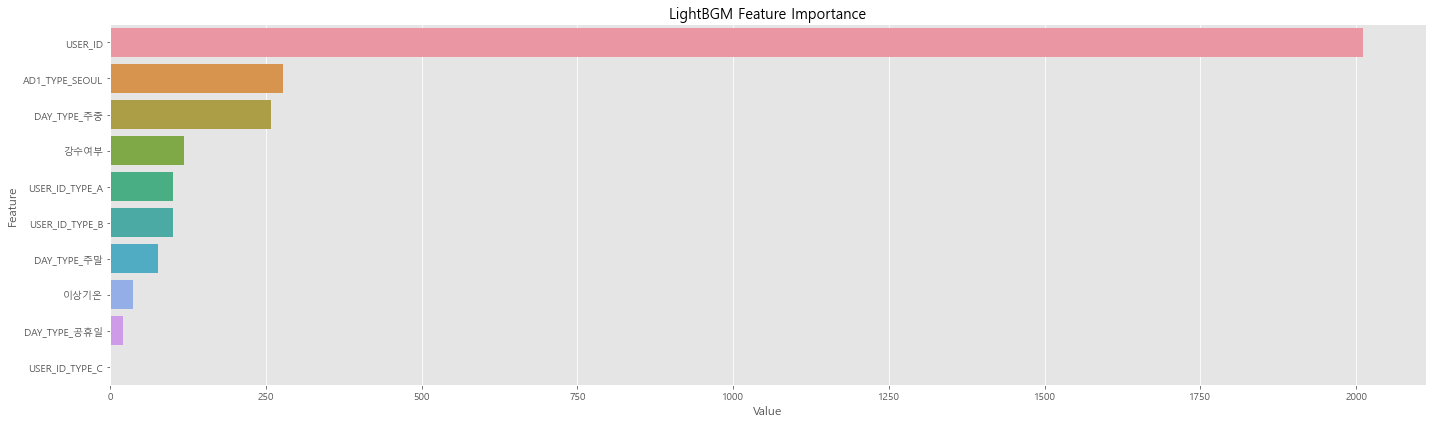

In [79]:
# Feature importance
feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_,train_x.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 6))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).head(20))
plt.title('LightBGM Feature Importance')
plt.tight_layout()
plt.show()